In [15]:
import os
import re
import sys
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sktime.datasets import load_from_tsfile_to_dataframe

sys.path.append("../..")
from data_provider.uea import subsample, interpolate_missing, Normalizer

In [23]:
def load_single(filepath):
    df, labels = load_from_tsfile_to_dataframe(filepath, return_separate_X_and_y=True,
                                                            replace_missing_vals_with='NaN')
    labels = pd.Series(labels, dtype="category")
    class_names = labels.cat.categories
    labels_df = pd.DataFrame(labels.cat.codes,
                                dtype=np.int8)  # int8-32 gives an error when using nn.CrossEntropyLoss

    lengths = df.applymap(
        lambda x: len(x)).values  # (num_samples, num_dimensions) array containing the length of each series

    horiz_diffs = np.abs(lengths - np.expand_dims(lengths[:, 0], -1))

    if np.sum(horiz_diffs) > 0:  # if any row (sample) has varying length across dimensions
        df = df.applymap(subsample)

    lengths = df.applymap(lambda x: len(x)).values
    vert_diffs = np.abs(lengths - np.expand_dims(lengths[0, :], 0))
    if np.sum(vert_diffs) > 0:  # if any column (dimension) has varying length across samples
        max_seq_len = int(np.max(lengths[:, 0]))
    else:
        max_seq_len = lengths[0, 0]

    # First create a (seq_len, feat_dim) dataframe for each sample, indexed by a single integer ("ID" of the sample)
    # Then concatenate into a (num_samples * seq_len, feat_dim) dataframe, with multiple rows corresponding to the
    # sample index (i.e. the same scheme as all datasets in this project)

    df = pd.concat((pd.DataFrame({col: df.loc[row, col] for col in df.columns}).reset_index(drop=True).set_index(
        pd.Series(lengths[row, 0] * [row])) for row in range(df.shape[0])), axis=0)

    # Replace NaN values
    grp = df.groupby(by=df.index)
    df = grp.transform(interpolate_missing)

    return df, labels_df
    

def load_all(root_path, file_list=None, flag=None):
    """
    Loads datasets from csv files contained in `root_path` into a dataframe, optionally choosing from `pattern`
    Args:
        root_path: directory containing all individual .csv files
        file_list: optionally, provide a list of file paths within `root_path` to consider.
            Otherwise, entire `root_path` contents will be used.
    Returns:
        all_df: a single (possibly concatenated) dataframe with all data corresponding to specified files
        labels_df: dataframe containing label(s) for each sample
    """
    # Select paths for training and evaluation
    if file_list is None:
        data_paths = glob.glob(os.path.join(root_path, '*'))  # list of all paths
    else:
        data_paths = [os.path.join(root_path, p) for p in file_list]
    if len(data_paths) == 0:
        raise Exception('No files found using: {}'.format(os.path.join(root_path, '*')))
    if flag is not None:
        data_paths = list(filter(lambda x: re.search(flag, x), data_paths))
    input_paths = [p for p in data_paths if os.path.isfile(p) and p.endswith('.ts')]
    print(f"input_paths: {input_paths}")
    if len(input_paths) == 0:
        pattern='*.ts'
        raise Exception("No .ts files found using pattern: '{}'".format(pattern))

    all_df, labels_df = load_single(input_paths[0])  # a single file contains dataset

    return all_df, labels_df

In [24]:
root_path = '../../dataset/classification/UEA/Heartbeat'
all_df, labels_df = load_all(root_path, file_list=None, flag="TRAIN")

input_paths: ['../../dataset/classification/UEA/Heartbeat/Heartbeat_TRAIN.ts']


/var/folders/zk/57rbvkps16qdk3nyj62f4wyw0000gn/T/ipykernel_32376/323515125.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = df.applymap(
/var/folders/zk/57rbvkps16qdk3nyj62f4wyw0000gn/T/ipykernel_32376/323515125.py:17: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  lengths = df.applymap(lambda x: len(x)).values


In [22]:
all_df

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60
0,0.000949,0.001288,0.000529,0.000563,0.000980,0.001009,0.001464,0.002277,0.001552,0.000708,...,0.001950,0.020030,0.035233,0.041325,0.048396,0.039963,0.078962,0.078312,0.045608,0.121070
0,0.001488,0.001140,0.001635,0.001082,0.001680,0.001782,0.000935,0.001225,0.001347,0.000268,...,0.014218,0.012354,0.022914,0.025636,0.021956,0.036272,0.085931,0.145680,0.119800,0.133850
0,0.000314,0.000430,0.002146,0.000610,0.001279,0.002249,0.000397,0.001563,0.000330,0.000971,...,0.039978,0.036798,0.036099,0.041923,0.052983,0.039156,0.110610,0.238050,0.178130,0.040077
0,0.000995,0.000532,0.001744,0.000445,0.001592,0.000938,0.000240,0.001269,0.000169,0.000652,...,0.052157,0.053817,0.050959,0.065993,0.096772,0.083629,0.165070,0.265630,0.150210,0.061956
0,0.002099,0.001492,0.001424,0.000796,0.001521,0.000591,0.000554,0.001469,0.001343,0.000715,...,0.030683,0.041912,0.026441,0.049231,0.078987,0.149420,0.245120,0.186530,0.066619,0.070956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
203,0.005072,0.002829,0.001588,0.006018,0.011885,0.002574,0.006266,0.006309,0.013291,0.017248,...,0.011872,0.033656,0.033050,0.033799,0.049153,0.071279,0.067396,0.081201,0.131550,0.031515
203,0.005831,0.002387,0.002514,0.004973,0.011910,0.006155,0.004932,0.002476,0.011635,0.012985,...,0.007311,0.036839,0.032488,0.020085,0.025653,0.038853,0.127560,0.183250,0.177930,0.066749
203,0.007455,0.006783,0.004723,0.006756,0.012059,0.008155,0.002254,0.002549,0.007925,0.005576,...,0.016262,0.032110,0.026859,0.022696,0.042071,0.048182,0.201120,0.280130,0.158690,0.101930
203,0.008124,0.009142,0.005436,0.005101,0.007947,0.007861,0.000964,0.001796,0.004098,0.006673,...,0.013833,0.014482,0.044743,0.050033,0.044775,0.102920,0.226500,0.270960,0.068071,0.062402


In [10]:
labels_df

,0
0,1
1,1
2,1
3,1
4,1
...,...
199,0
200,0
201,0
202,0


In [12]:
seq_len = int(all_df.shape[0] / labels_df.shape[0])
print(f"seq_len: {seq_len}")

seq_len: 405


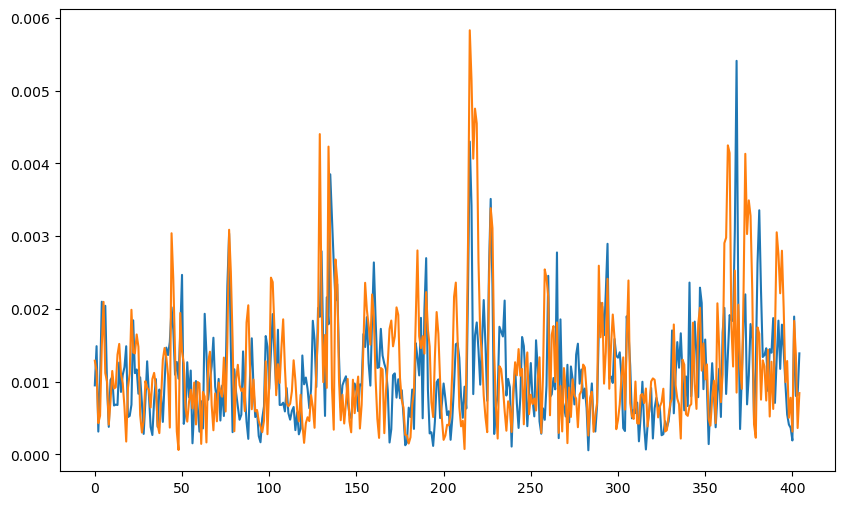

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(all_df.values[:405, 0])
plt.plot(all_df.values[:405, 1])

In [19]:
all_IDs = all_df.index.unique()
all_IDs

Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
       ...
       194, 195, 196, 197, 198, 199, 200, 201, 202, 203],
      dtype='int64', length=204)

In [20]:
all_df.loc[0]

,dim_0,dim_1,dim_2,dim_3,dim_4,dim_5,dim_6,dim_7,dim_8,dim_9,...,dim_51,dim_52,dim_53,dim_54,dim_55,dim_56,dim_57,dim_58,dim_59,dim_60
0,0.000949,0.001288,0.000529,0.000563,0.000980,0.001009,0.001464,0.002277,0.001552,0.000708,...,0.001950,0.020030,0.035233,0.041325,0.048396,0.039963,0.078962,0.078312,0.045608,0.121070
0,0.001488,0.001140,0.001635,0.001082,0.001680,0.001782,0.000935,0.001225,0.001347,0.000268,...,0.014218,0.012354,0.022914,0.025636,0.021956,0.036272,0.085931,0.145680,0.119800,0.133850
0,0.000314,0.000430,0.002146,0.000610,0.001279,0.002249,0.000397,0.001563,0.000330,0.000971,...,0.039978,0.036798,0.036099,0.041923,0.052983,0.039156,0.110610,0.238050,0.178130,0.040077
0,0.000995,0.000532,0.001744,0.000445,0.001592,0.000938,0.000240,0.001269,0.000169,0.000652,...,0.052157,0.053817,0.050959,0.065993,0.096772,0.083629,0.165070,0.265630,0.150210,0.061956
0,0.002099,0.001492,0.001424,0.000796,0.001521,0.000591,0.000554,0.001469,0.001343,0.000715,...,0.030683,0.041912,0.026441,0.049231,0.078987,0.149420,0.245120,0.186530,0.066619,0.070956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.000192,0.000314,0.000354,0.000557,0.001457,0.001211,0.002307,0.001379,0.001394,0.000890,...,0.017010,0.014761,0.023285,0.056559,0.130840,0.163370,0.127830,0.177860,0.338300,0.260460
0,0.001895,0.001836,0.001881,0.002584,0.001107,0.002020,0.004083,0.000464,0.002499,0.002683,...,0.031272,0.021400,0.055557,0.082046,0.083323,0.213620,0.175940,0.260190,0.373050,0.048439
0,0.000804,0.001364,0.001179,0.001672,0.001009,0.002163,0.001040,0.002411,0.002220,0.001268,...,0.064209,0.084249,0.145580,0.190040,0.139600,0.302290,0.030819,0.440700,0.379340,0.098976
0,0.000815,0.000363,0.000363,0.000614,0.001065,0.000894,0.002305,0.002152,0.001520,0.001349,...,0.090335,0.106120,0.184410,0.280280,0.327920,0.441500,0.395520,0.632770,0.373870,0.025955
